# Chat Intents

## Clustering without dimensionality reduction

**Summary**

This notebook briefly explores a few methods for representing documents with different embedding methods and clustering the embeddings with different algorithsm. In contrast to notebooks 04 and 05 in this repo, here no dimensionality reduction is used. As shown below, the biggest challene here remains selecting the right hyperparameters when the number of clusters isn't already known.

In [1]:
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import hdbscan
import tensorflow as tf
import tensorflow_hub as hub
from sentence_transformers import SentenceTransformer

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("max_colwidth", 400)

In [2]:
data_sample = pd.read_csv('../data/processed/data_sample.csv')
data_sample.head()

,Unnamed: 0,text,category,cleaned_text
0,1024,I'm worried my card might be lost in the mail? How long does it usually take to arrive?,card_delivery_estimate,im worried card might lost mail long usually take arrive
1,9405,I got charged a fee that shouldn't be there from my cash,cash_withdrawal_charge,got charged fee shouldnt cash
2,9368,Do you charge for making a withdrawal? I took some money out of my account earlier and I was charged for this.,cash_withdrawal_charge,charge making withdrawal took money account earlier charged
3,3414,Is there an issue with my account? I don't see a cheque deposit that I made yesterday. Please assist.,balance_not_updated_after_cheque_or_cash_deposit,issue account dont see cheque deposit made yesterday please assist
4,7402,Are there ways for other people to send me money?,receiving_money,way people send money


### Helper functions

In [3]:
def plot_kmeans(embeddings, k_range):
    '''
    Plot SSE and silhouette score for kmeans clustering for a range of k values
    Arguments:
        embeddings: array, sentence embeddings
        k_range: range, values of k to evaluate for kmeans clustering  
    '''
    sse = []
    silhouette_avg_n_clusters = []

    for k in k_range:
        kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1)
        kmeans.fit(embeddings)
        sse.append(kmeans.inertia_)

        silhouette_avg = silhouette_score(embeddings, kmeans.predict(embeddings))
        silhouette_avg_n_clusters.append(silhouette_avg)


    # plot sse
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    axes[0].plot(k_range, sse)
    axes[0].set(xlabel = 'k clusters', ylabel = 'SSE', title = 'Elbow plot')
    axes[0].grid()
    
    # plot avg silhouette score
    axes[1].plot(k_range, silhouette_avg_n_clusters)
    axes[1].set(xlabel = 'k clusters', ylabel = 'Silhouette score', title = 'Silhouette score')
    axes[1].grid()

    plt.show()

In [4]:
def search_cluster_size(embeddings, size_range):
    '''
    Scan HDBSCAN min_cluster_size values and return results
    Arguments:
        embeddings: embeddings to use
        size_range: range of min_cluster_size hyperparameter values to scan
    Returns:
        result_df: dataframe of min_cluster_size, total number of clusters,
                   and percent of data labeled as noise
    '''
    
    results = []
    
    for i in size_range:
        min_cluster_size = i
        
        clusters_hdbscan = (hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                                           metric='euclidean', 
                                           cluster_selection_method='eom') 
                                           .fit(embeddings))
    
        labels = clusters_hdbscan.labels_
        label_count = len(np.unique(labels))
        
        total_num = len(clusters_hdbscan.labels_)
        cost = (np.count_nonzero(clusters_hdbscan.probabilities_ < 0.05)/total_num) 
                
        results.append([min_cluster_size, label_count, cost])
    
    result_df = pd.DataFrame(results, columns=['min_cluster_size', 
                                               'label_count', 'noise'])
    
    return result_df

In [5]:
def random_search(embeddings, space, num_evals):
    '''
    Random search of HDBSCAN hyperparameter spcae
    Arguments:
        embeddings: embeddings to use
        space: dict, hyperparameter space to search with keys of
               'min_cluster_size' and 'min_samples' and values as ranges
        num_evals: int, number of trials to run
    Returns:
        result_df: dataframe of run_id, min_cluster_size, min_samples, 
                   total number of clusters, and percent of data labeled as noise
    
    '''
    
    results = []
    
    for i in range(num_evals):
        min_cluster_size = random.choice(space['min_cluster_size'])
        min_samples = random.choice(space['min_samples'])
        
        clusters_hdbscan = (hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                                           min_samples = min_samples,
                                           metric='euclidean', 
                                           cluster_selection_method='eom') 
                                           .fit(embeddings))
    
        labels = clusters_hdbscan.labels_
        label_count = len(np.unique(labels))
        
        total_num = len(clusters_hdbscan.labels_)
        cost = (np.count_nonzero(clusters_hdbscan.probabilities_ < 0.05)/total_num) 
                
        results.append([i, min_cluster_size, min_samples, label_count, cost])
    
    result_df = pd.DataFrame(results, columns=['run_id', 'min_cluster_size', 'min_samples', 
                                               'label_count', 'cost'])
    
    return result_df.sort_values(by='cost')

### TF-IDF embeddings with K-means

In [6]:
cleaned_text = data_sample['cleaned_text']
cleaned_text.head()

0              im worried card might lost mail long usually take arrive
1                                         got charged fee shouldnt cash
2           charge making withdrawal took money account earlier charged
3    issue account dont see cheque deposit made yesterday please assist
4                                                 way people send money
Name: cleaned_text, dtype: object

In [7]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_transformed_vector = tfidf_vectorizer.fit_transform(cleaned_text)
tfidf_transformed_vector.shape

(1000, 809)

In [8]:
k = 10
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1)
kmeans.fit(tfidf_transformed_vector)

KMeans(max_iter=100, n_clusters=10, n_init=1)

In [9]:
len(kmeans.labels_)

1000

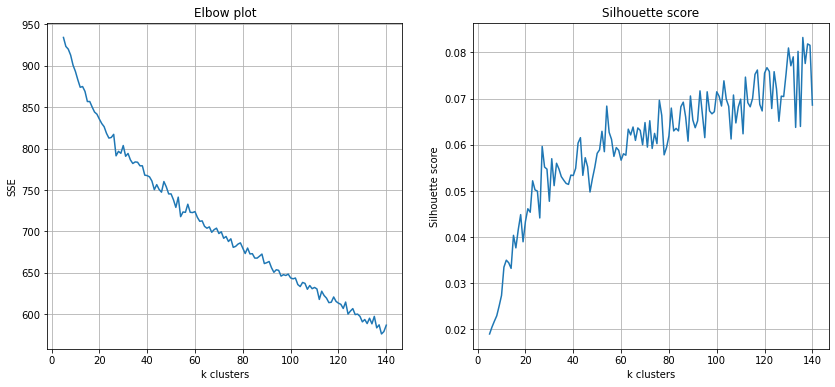

CPU times: user 42 s, sys: 1.26 s, total: 43.3 s
Wall time: 19.7 s


In [10]:
%%time

k_range = range(5, 141)
plot_kmeans(tfidf_transformed_vector, k_range)

There's no clear elbow in the scree plot of the sum of squared errors as a function of the number of clusters (k). Additionally, the silhouette score appears to continue increasing over the range considered. Thus, neither approach makes it clear what value to select for k.

## Sentence Embeddings

The sentence embedding models typically expect raw sentences (without preprocessing), so we'll use those here.

In [11]:
full_text = data_sample['text']

### USE Sentence Embeddings + Kmeans

Start with Universal Sentence Encoder (USE) as an example sentence embedding model.

In [12]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model_use = hub.load(module_url)

print(f"module {module_url} loaded")

INFO:absl:Using /var/folders/_d/glx67tx142z43y0r2thyl3g80000gn/T/tfhub_modules to cache modules.


module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [13]:
use_embeddings = model_use(full_text)
use_embeddings.shape

TensorShape([1000, 512])

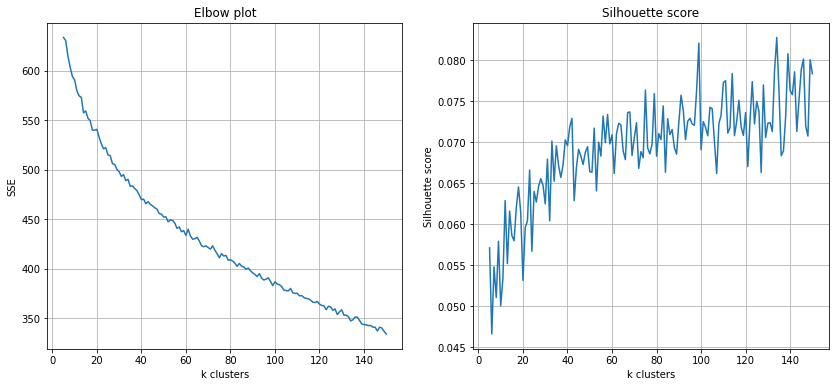

CPU times: user 1min 1s, sys: 2.41 s, total: 1min 3s
Wall time: 27.1 s


In [14]:
%%time

k_range = range(5, 151)
plot_kmeans(use_embeddings, k_range)

As with the TF-IDF embeddings above, it's not obvious what number of clusters to select from these plots. The silhouette score continues to slowly increase as the number of clusters increases. Even at 150 clusters though, the silhouette score has only reached 0.08, which is quite low.

### Sentence Transformer Embeddings + Kmeans

Use a sentence-transformer pretrained model that was made in a way to preserve the usefulness of Euclidean distances (https://www.sbert.net/docs/pretrained_models.html). 

In [15]:
model_st = SentenceTransformer('all-mpnet-base-v2')
st_embeddings = model_st.encode(full_text)
st_embeddings.shape

(1000, 768)

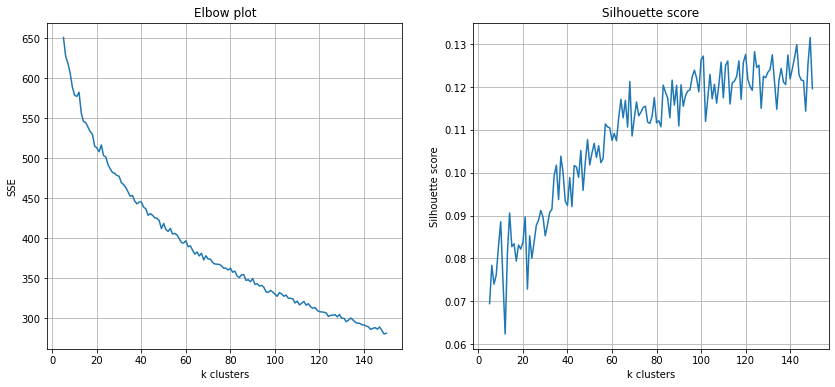

CPU times: user 1min 40s, sys: 5.5 s, total: 1min 45s
Wall time: 46.7 s


In [16]:
%%time

k_range = range(5, 151)
plot_kmeans(st_embeddings, k_range)

As with the USE model, it still isn't obvious what value of k to select. From the silhouette score plot we see that the values seem to somewhat level off starting at around 100 clusters, but it also continues to slowly rise from there.

### Hierarchical clustering

In [17]:
# Normalize the embeddings to unit length
st_embeddings_norm = st_embeddings /  np.linalg.norm(st_embeddings, axis=1, keepdims=True)

In [18]:
# Perform clustering
agglom_model = AgglomerativeClustering(n_clusters=None, distance_threshold=1.5)
agglom_model.fit(st_embeddings_norm)
cluster_assignment = agglom_model.labels_

len(np.unique(cluster_assignment))

118

While we can obvoiusly create clusters using hierarchical clustering, we still have no way to intuitively select the necessary hyperparameters (e.g. distance_threshold in this case).

### Sentence Embeddings + HDBSCAN

In [19]:
clusters_hdbscan = hdbscan.HDBSCAN(min_cluster_size=2, 
                                   metric='euclidean', 
                                   cluster_selection_method='eom').fit(st_embeddings)

labels = clusters_hdbscan.labels_
len(np.unique(labels))

232

In [20]:
pd.Series(labels).value_counts().head(10)

-1      255
 91      18
 145     12
 151     10
 216     10
 114     10
 60       8
 98       8
 197      8
 202      7
dtype: int64

In [21]:
size_range = range(2,11)
search_cluster_size(st_embeddings, size_range=size_range)

,min_cluster_size,label_count,noise
0,2,232,0.255
1,3,88,0.381
2,4,3,0.016
3,5,40,0.591
4,6,3,0.082
5,7,4,0.300
6,8,3,0.348
7,9,14,0.722
8,10,10,0.784


Scanning through different min_cluster_size values for HDBSCAN reveals some of the challenges of using the raw sentence embeddings. Either all the datapoints are lumped into the same, small number of clusters (e.g. 3 total), or a large percentage of datapoints are not clustered (e.g. 38% of the data is left out as noise with a min_cluster_size of 3).

In [22]:
%%time

space = {
    "min_cluster_size": range(2, 30),
    "min_samples": range(2, 30)
}

random_search(st_embeddings, space, num_evals=100).head(20)

CPU times: user 2min 7s, sys: 816 ms, total: 2min 8s
Wall time: 2min 17s


,run_id,min_cluster_size,min_samples,label_count,cost
33,33,2,4,3,0.016
20,20,2,28,3,0.061
35,35,13,2,3,0.073
67,67,22,2,3,0.073
72,72,13,2,3,0.073
85,85,5,6,3,0.082
92,92,15,3,3,0.097
74,74,2,12,3,0.125
49,49,20,4,3,0.142
31,31,17,4,3,0.142


Decoupling min_samples separate from min_cluster_size doesn't improve our results (min_samples is set equal to min_cluster_size by default in HDBSCAN if it is not specified). We still see the same issues here or either too few clusters or too many samples being labeled as noise.